In [45]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from google.colab import drive

#mount drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/SecurityProject

#read data
fname = "data_tcp_600.csv"
stream = os.popen("find . -name '%s'" % fname)
fpath = stream.read()[:-1]
data_tcp_original= pd.read_csv(fpath)
fname = "data_udp_10.csv"
stream = os.popen("find . -name '%s'" % fname)
fpath = stream.read()[:-1]
data_udp_original = pd.read_csv(fpath)
fname = "data_icmp_60.csv"
stream = os.popen("find . -name '%s'" % fname)
fpath = stream.read()[:-1]
data_icmp_original = pd.read_csv(fpath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/SecurityProject


In [46]:
feature1 = 'ts'
feature2 = 'src_ip'
feature3 = 'src_port'
feature4 = 'dst_ip'
feature5 = 'dst_port'
feature6 = 'pck_len'
feature7 = 'tcp_flags'
feature8 = 'cluster'
feature9 = 'user'
feature10 = 'num_attack'
feature11 = 'first_port_scan'
feature12 = 'ip_diff'
feature13 = 'port_diff'
feature14 = 'range_ip'
feature15 = 'range_port'
feature16 = 'ip_medium'
feature17 = 'ip_std'
feature18 = 'port_medium'
feature19 = 'port_std'
feature20 = 'pck_medium'
feature21 = 'pck_std'

#drop some artificial feature 
#data_tcp_original.drop([feature10,feature12,feature13,feature14,feature15], axis = 1,inplace=True)
#data_udp_original.drop([feature10,feature12,feature13,feature14,feature15], axis = 1,inplace=True)
#data_icmp_original.drop([feature10,feature12,feature14], axis = 1,inplace=True)

#drop duplicates
data_tcp_rm = data_tcp_original.drop_duplicates(subset=['user'])
data_udp_rm = data_udp_original.drop_duplicates(subset=['user'])
data_icmp_rm = data_icmp_original.drop_duplicates(subset=['user'])

In [47]:
#display created clusters
def print_clusters(df, num_cluster=10, title=''):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
  final_df = pd.concat([principalDf, df[['cluster']]], axis = 1)
  final_df.dropna(inplace=True)
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(title, fontsize = 20)
  targets = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
  colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'darkorange', 'darkblue', 'pink']
  i=1
  for target, color in zip(targets,colors):
      indicesToKeep = final_df['cluster'] == target
      ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
                , final_df.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
      i=i+1
      if i>num_cluster:
        break
  ax.legend(targets)
  ax.grid()


# calculate clusters
def cluster(df, features, _n_clusters=0.3):
  #rescaling dataset and setting feature
  df_rescaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

  #clusters creation with BIRCH
  kmeans = KMeans(_n_clusters)

  labels = kmeans.fit_predict(df_rescaled[features])
  #label assignment 
  df_rescaled['cluster'] = labels

  #calculate clusters' size
  detail = df_rescaled.groupby(['cluster']).size()

  return df_rescaled, labels, detail 

# TCP Cluster

In [48]:
#features for clustering
#features=[feature9,feature11,feature16,feature17,feature18,feature19,feature20,feature21]
features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

#rescaled_data_tcp_rm, tcp_labels, detail=cluster(data_tcp_rm, features, 2, 0.2, 5)
rescaled_data_tcp_rm, tcp_labels, detail=cluster(data_tcp_rm, features, 4)

print("TCP cluster's details\n", detail)

TCP cluster's details
 cluster
0     1356
1    23286
2      125
3      972
dtype: int64



*Performance* 



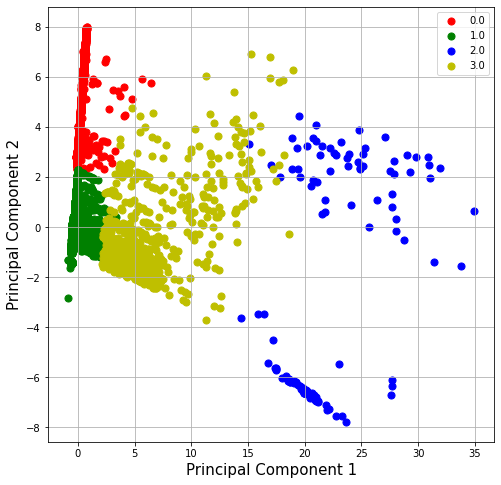

In [49]:
#remove not used data for clustering
rescaled_data_tcp_rm.drop([feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature9], axis = 1,inplace=True)

#print clusters
print_clusters(rescaled_data_tcp_rm, 4)

In [50]:
score_tcp = silhouette_score(rescaled_data_tcp_rm,rescaled_data_tcp_rm['cluster'])
print(score_tcp)

0.5961314092820018


# UDP Cluster

In [51]:
#features for clustering
#features=[feature9,feature11,feature16,feature17,feature18,feature19,feature20,feature21]
features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

#rescaled_data_udp_rm, udp_labels, detail=cluster(data_udp_rm, features,4, 0.1, 50)
rescaled_data_udp_rm, udp_labels, detail=cluster(data_udp_rm, features,4)

print("UDP cluster's details\n", detail)

UDP cluster's details
 cluster
0    3463
1      36
2       4
3     363
dtype: int64


*Performance*

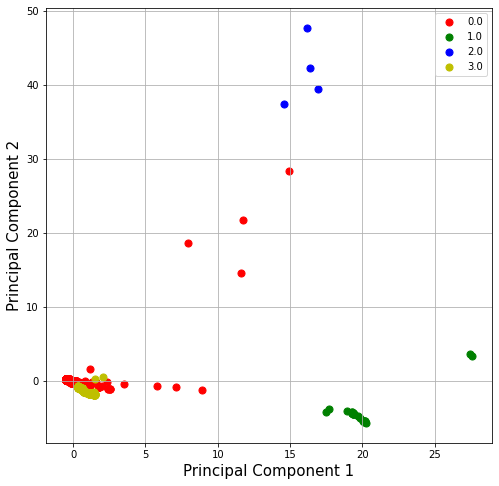

In [52]:
#remove not used data for clustering
rescaled_data_udp_rm.drop([feature1,feature2,feature3,feature4,feature5,feature6,feature9], axis = 1,inplace=True)

#print clusters
print_clusters(rescaled_data_udp_rm, 4)

In [53]:
score_udp = silhouette_score(rescaled_data_udp_rm,rescaled_data_udp_rm['cluster'])
print(score_udp)

0.7116561885592927


## ICMP Cluster

In [54]:
#features for clustering
#features=[feature9,feature16,feature17,feature20,feature21]
features=[feature10,feature12,feature14,feature16,feature17,feature20,feature21]

#rescaled_data_icmp, icmp_labels, detail=cluster(data_icmp_rm, features,8, 0.1, 10)
rescaled_data_icmp, icmp_labels, detail=cluster(data_icmp_rm, features,4)

print("ICMP cluster's details\n", detail)

ICMP cluster's details
 cluster
0    95
1     1
2    66
3     8
dtype: int64


*Performance*

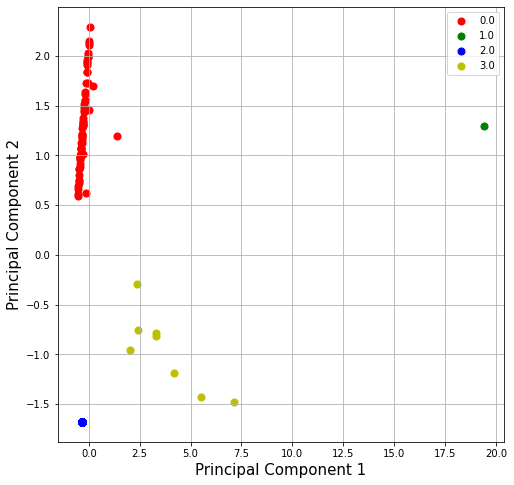

In [55]:
#remove not used data for clustering
rescaled_data_icmp.drop([feature1,feature2,feature4,feature6,feature9], axis = 1,inplace=True)

#print clusters
print_clusters(rescaled_data_icmp,  4)

In [56]:
score_icmp = silhouette_score(rescaled_data_icmp,rescaled_data_icmp['cluster'])
print(score_icmp)

0.7354290207925678


# Early Classification Performance

In [57]:
#set cluster labels to original dfs
data_tcp_rm['cluster'] = tcp_labels
data_udp_rm['cluster'] = udp_labels
data_icmp_rm['cluster'] = icmp_labels
new_data = [data_tcp_rm,data_udp_rm,data_icmp_rm]
old_data = [data_tcp_original,data_udp_original,data_icmp_original]
results = []
for i in range(0,len(new_data)):
  cluster = []
  map_user = {}
  for index,row in new_data[i].iterrows():
    map_user[row['user']] = row['cluster']
  for index,row in old_data[i].iterrows():
    cluster.append(map_user[row['user']])
  cluster_np = np.asarray(cluster)
  cluster = cluster_np.reshape((cluster_np.size,1))
  rescaled_data = pd.DataFrame(StandardScaler().fit_transform(old_data[i]), columns=old_data[i].columns)
  rescaled_data['cluster'] = cluster
  results.append(rescaled_data)  
old_data_tcp = results[0]
old_data_udp = results[1]
old_data_icmp = results[2]

In [58]:
#remove artifical features
#old_data_tcp.drop([feature9,feature11,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)
#old_data_udp.drop([feature9,feature11,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)
#old_data_icmp.drop([feature9,feature16,feature17,feature20,feature21], axis = 1,inplace=True)
old_data_tcp.drop([feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)
old_data_udp.drop([feature9, feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)
old_data_icmp.drop([feature9,feature10,feature12,feature14,feature16,feature17,feature20,feature21], axis = 1,inplace=True)

#evaluating clustering perfomances 
score_tcp = silhouette_score(old_data_tcp,old_data_tcp['cluster'])
score_udp = silhouette_score(old_data_udp,old_data_udp['cluster'])
score_icmp = silhouette_score(old_data_icmp,old_data_icmp['cluster'])
print(score_tcp)
print(score_udp)
print(score_icmp)

0.11560687047586923
0.3042836909171769
0.5108349444315111


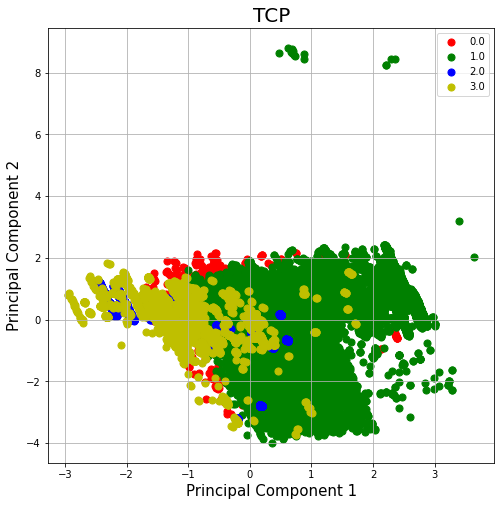

In [59]:
#TCP
print_clusters(old_data_tcp,4,'TCP')

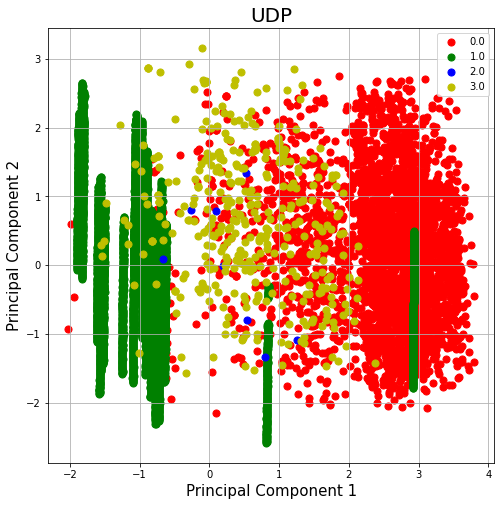

In [60]:
#UDP
print_clusters(old_data_udp,4,'UDP')

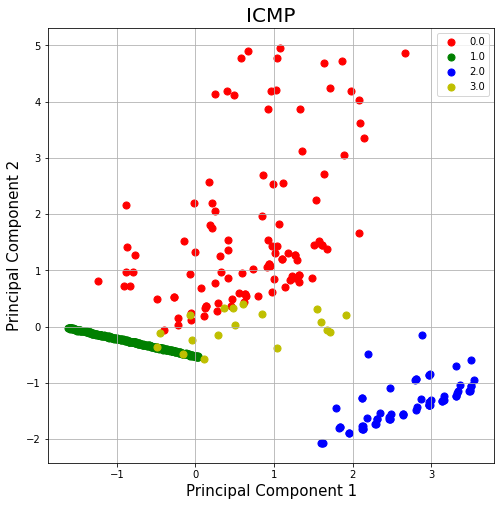

In [61]:
#ICMP
print_clusters(old_data_icmp,4,'ICMP')

First scanned port

Score First Port TCP 0.7790469982308328





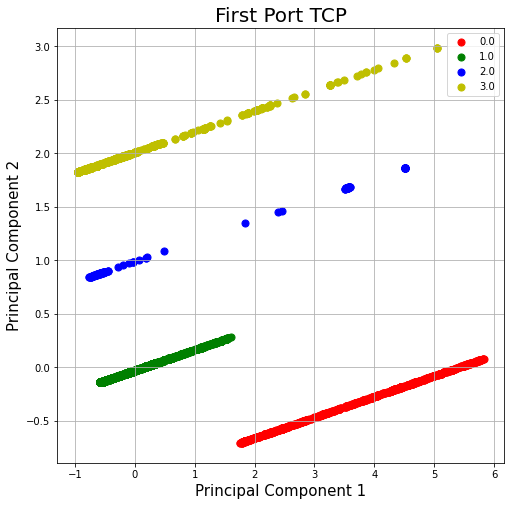

In [62]:
#TCP 

#remove features
rescaled_data_tcp_rm.drop([feature10,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)

#print clusters
print_clusters(rescaled_data_tcp_rm, 4,"First Port TCP")


score_tcp = silhouette_score(rescaled_data_tcp_rm,rescaled_data_tcp_rm['cluster'])
print("Score First Port TCP",score_tcp)
print("\n\n")

Score First Port UDP 0.865049460630539





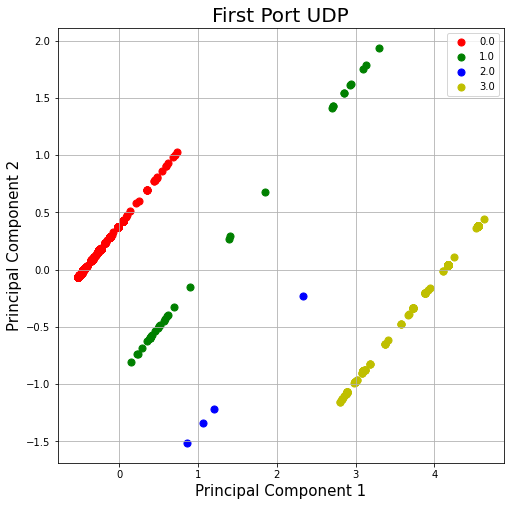

In [63]:
#UDP

#remove features
rescaled_data_udp_rm.drop([feature10,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)

#print clusters
print_clusters(rescaled_data_udp_rm, 4, "First Port UDP")

score_udp = silhouette_score(rescaled_data_udp_rm,rescaled_data_udp_rm['cluster'])
print("Score First Port UDP",score_udp)
print("\n\n")